In [15]:
from io import StringIO
import requests
import pandas as pd
import config
import nbformat
import time
from nbconvert.preprocessors import ExecutePreprocessor
import matplotlib.pyplot as plt

In [16]:

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol=IBM&datatype=csv&apikey=' + config.api_key

r = requests.get(url)

csv_data = r.text

df1 = pd.read_csv(StringIO(csv_data))

df1 = df1[::-1]

df1.reset_index(drop=True, inplace=True)

df1



,timestamp,open,high,low,close,volume
0,1999-11-01,98.50,98.8100,96.37,96.75,9551800
1,1999-11-02,96.75,96.8100,93.69,94.81,11105400
2,1999-11-03,95.87,95.9400,93.50,94.37,10369100
3,1999-11-04,94.44,94.4400,90.00,91.56,16697600
4,1999-11-05,92.75,92.9400,90.19,90.25,13737600
...,...,...,...,...,...,...
6136,2024-03-22,192.00,192.9850,190.51,190.84,3988398
6137,2024-03-25,190.26,190.8200,188.75,188.79,3718289
6138,2024-03-26,189.02,190.0000,188.50,188.50,4229535
6139,2024-03-27,189.60,190.9600,188.60,190.80,3693305


In [17]:
df1

,timestamp,open,high,low,close,volume
0,1999-11-01,98.50,98.8100,96.37,96.75,9551800
1,1999-11-02,96.75,96.8100,93.69,94.81,11105400
2,1999-11-03,95.87,95.9400,93.50,94.37,10369100
3,1999-11-04,94.44,94.4400,90.00,91.56,16697600
4,1999-11-05,92.75,92.9400,90.19,90.25,13737600
...,...,...,...,...,...,...
6136,2024-03-22,192.00,192.9850,190.51,190.84,3988398
6137,2024-03-25,190.26,190.8200,188.75,188.79,3718289
6138,2024-03-26,189.02,190.0000,188.50,188.50,4229535
6139,2024-03-27,189.60,190.9600,188.60,190.80,3693305


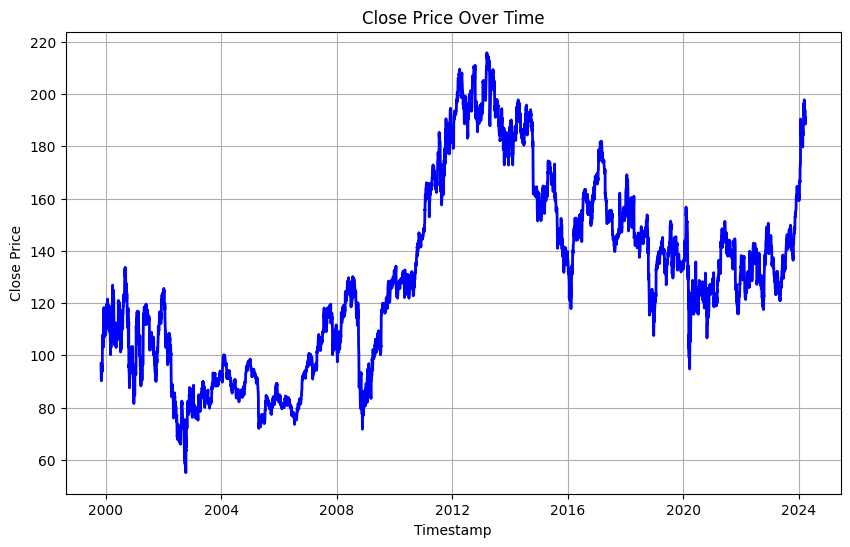

In [18]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])


plt.figure(figsize=(10, 6))
plt.plot(df1['timestamp'], df1['close'], color='blue', linewidth=2)
plt.title('Close Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [24]:
from prophet import Prophet

In [21]:
df = df1[["close", "timestamp"]]

In [23]:
df = df.assign(ds = df.get("timestamp"), y = df.get("close")).get(["y", "ds"])
df

,y,ds
0,96.75,1999-11-01
1,94.81,1999-11-02
2,94.37,1999-11-03
3,91.56,1999-11-04
4,90.25,1999-11-05
...,...,...
6136,190.84,2024-03-22
6137,188.79,2024-03-25
6138,188.50,2024-03-26
6139,190.80,2024-03-27


In [25]:
prophet_model = Prophet()
prophet_model.fit(df)

17:12:36 - cmdstanpy - INFO - Chain [1] start processing
17:12:38 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future_dataset= prophet_model.make_future_dataframe(periods=1500, freq='d') # Next 15 YEARS OF DATA
future_dataset

,ds
0,1999-11-01
1,1999-11-02
2,1999-11-03
3,1999-11-04
4,1999-11-05
...,...
7636,2028-05-02
7637,2028-05-03
7638,2028-05-04
7639,2028-05-05


In [41]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,1999-11-01,107.774906,94.963980,120.465815
1,1999-11-02,107.738212,95.164990,121.057207
2,1999-11-03,107.659799,94.367423,120.157712
3,1999-11-04,107.708804,95.532735,120.265744
4,1999-11-05,107.558859,94.623242,119.755026


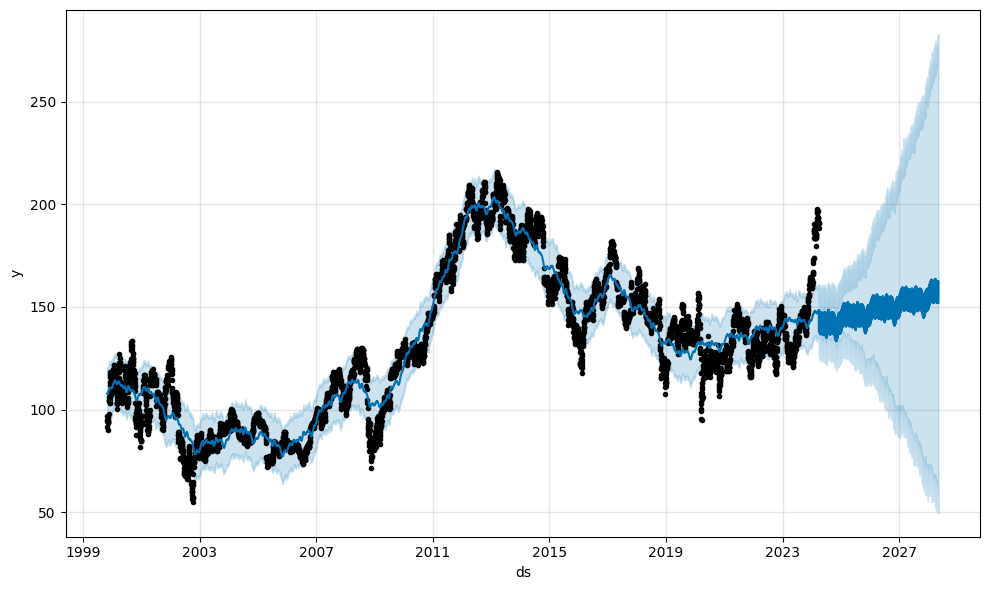

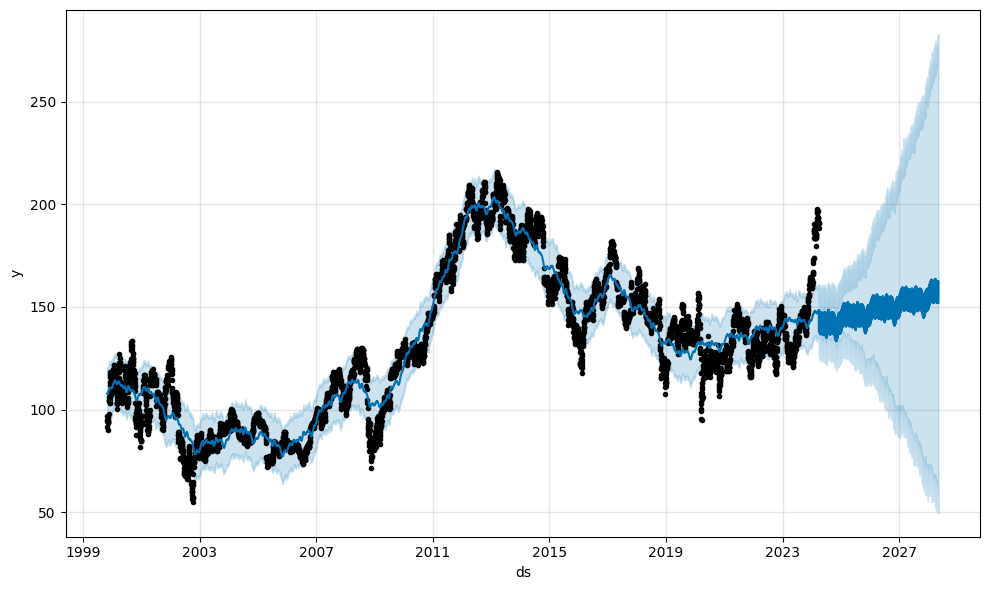

In [42]:
prophet_model.plot(pred)

In [50]:
def fb_prophet_function(data, future_days, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_days, freq='d')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7))
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [51]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout()

17:23:57 - cmdstanpy - INFO - Chain [1] start processing
17:24:05 - cmdstanpy - INFO - Chain [1] done processing


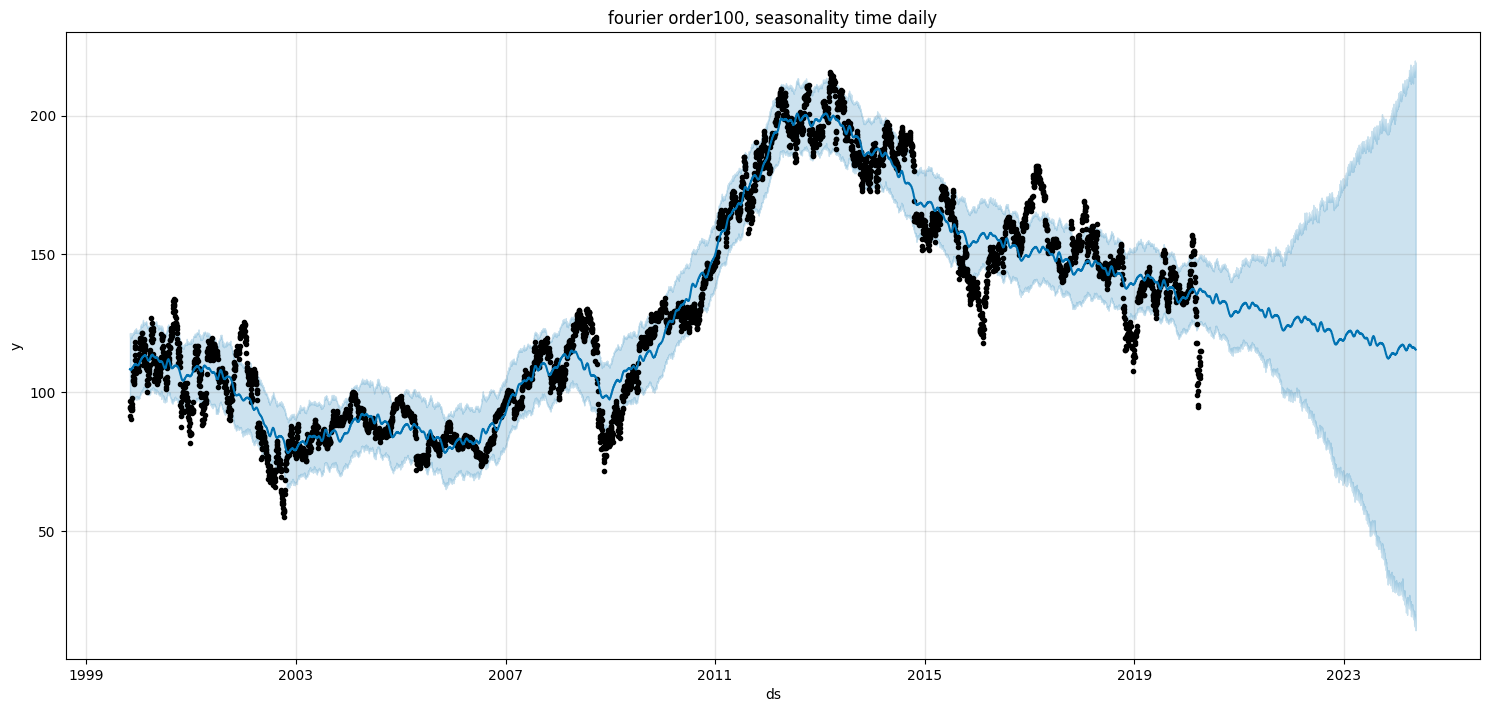

Total Execution Time 10.037945747375488 seconds


In [52]:
training_set = df[:-1000] 
validation_set = df[-1000:] #last 1000 rows, i.e from Jul 2018
# 15 years seasonlaity, additive, no other seasonality, less fourier value
fifteen_years = fb_prophet_function(data=training_set, future_days=1500, seasonality_name='daily', seasonality_val=1, seasonality_fourier=100,seasonality_mode='additive')

Text(0.5, 1.0, 'Hyp parameters: 15_years seasonality, seasonality_fourier=100, seasonality_mode=additive\n prediction from Jul2018-Apr2022(from training set i.e validation set)')

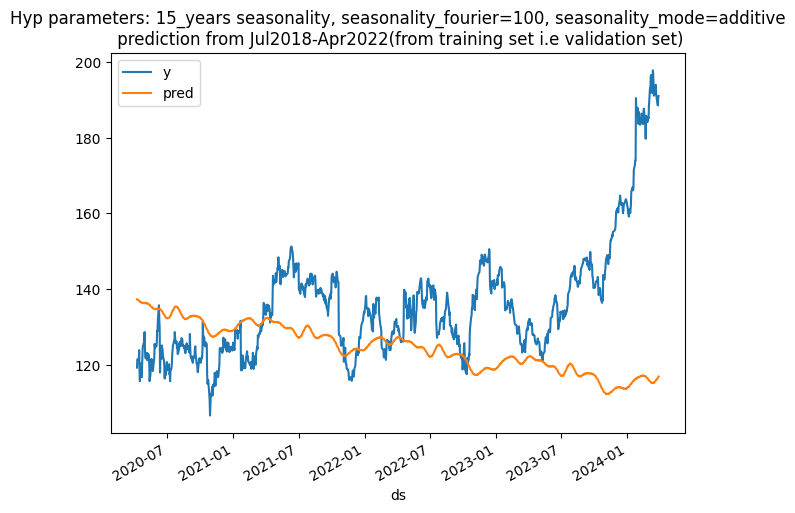

In [53]:
plot_valid(validation_set, 1000, fifteen_years)
plt.title("Hyp parameters: 15_years seasonality, seasonality_fourier=100, seasonality_mode=additive\n prediction from Jul2018-Apr2022(from training set i.e validation set)")